In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (precision_recall_curve, auc,
                             accuracy_score, classification_report)
from statannotations.Annotator import Annotator
from biom import load_table

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load data

In [2]:
#load rpca results
nPCs = 4
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord_{}PCs.txt'.format(nPCs))
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord_{}PCs.txt'.format(nPCs))
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord_{}PCs.txt'.format(nPCs))
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord_{}PCs.txt'.format(nPCs))
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord_{}PCs.txt'.format(nPCs))
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [3]:
print(metadata.shape)
display(metadata.head())

(374, 16)


,season,subjects,add_0c,add_0c_group,facility,timepoint,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
sample_name,,,,,,,,,,,,,,,,
soil.hip.CMU.17.10.2017.08.11.day3,summer,17-10,49.75,early,FIRS,3,train,train,train,test,train,test,test,test,train,train
soil.hip.CMU.17.10.2017.08.22.day14,summer,17-10,322.80,advanced,FIRS,14,test,train,train,train,test,train,train,train,test,train
soil.hip.CMU.17.10.2017.08.28.day20,summer,17-10,477.80,advanced,FIRS,20,train,test,train,train,test,train,test,train,train,train
soil.hip.CMU.17.10.2017.08.09.day1,summer,17-10,0.00,initial,FIRS,1,test,train,train,train,train,train,train,train,train,test
soil.hip.CMU.17.10.2017.08.23.day15,summer,17-10,348.05,advanced,FIRS,15,train,train,train,test,train,train,test,train,train,train


In [4]:
## NEED TO RUN ONLY ONCE
# create and save new set of train-test splits
# for i_ in range(10):
#     train, test = train_test_split(metadata, test_size=0.25, shuffle=True, random_state=i_,
#                                    stratify=metadata[['facility']])
#     metadata.loc[:, 'traintest_%i' % i_] = 'train'
#     metadata.loc[test.index, 'traintest_%i' % i_] = 'test'

# display(metadata.head())
# save data 
#metadata.to_csv('../network/split-matched-data/metadata_knn.tsv', sep='\t')

## Define functions

In [55]:
def knn_apr(ord_tables, ord_ids, shared_mt, 
            cat_of_interest, ordination=True,
            metric='AUC_APR'):

    #initialize dataframe to store results
    metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Group', metric, 'Report'])
    #metrics_df = pd.DataFrame()
    metric_ord = {}
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        #set up the classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        
        if ordination:
            X = ord.samples.copy()
        else:
            X = ord.copy()
            #examine if columns are sparse
            is_sparse = any(pd.api.types.is_sparse(X[col]) for col in X.columns)
            if is_sparse:
                X = X.sparse.to_dense()

        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        metric_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            knn.fit(X_train.values, y_train)

            #save classes or categories
            knn_classes = list(knn.classes_)

            if metric=='AUC_APR':
                y_proba = knn.predict_proba(X_test)
                print(y_proba.shape)
                apr_cat = {}
                for cat in y.unique():
                    cat_index = knn_classes.index(cat)
                    precision, recall, _ = precision_recall_curve(y_test, y_proba[:, cat_index],
                                                                  pos_label=cat)
                    apr = auc(x=recall, y=precision)
                    apr_cat[cat] = apr
                metric_fold[fold] = apr_cat
            
            elif metric=='Accuracy':
                #get accuracy and classification report
                y_pred = knn.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                report = classification_report(y_test, y_pred)
                #save results for each fold
                metric_fold[fold] = (accuracy, report)

        metric_ord[omic] = metric_fold

    #create df with metrics
    if metric=='AUC_APR':
        for omic, metric_fold in metric_ord.items():
            for fold, apr_cat in metric_fold.items():
                for cat, apr in apr_cat.items():
                    metrics_df = metrics_df._append({'Omic': omic, 'Fold': fold,
                                                     'Group': cat, metric: apr}, 
                                                     ignore_index=True)
        metrics_df.drop(columns=['Report'], inplace=True)

    elif metric=='Accuracy':
        for omic, metric_fold in metric_ord.items():
            for fold, acc_df in metric_fold.items():
                metrics_df = metrics_df._append({'Omic': omic, 'Fold': fold,
                                                 metric: acc_df[0], 
                                                 'Report': acc_df[1]},
                                                 ignore_index=True)
        metrics_df.drop(columns=['Group'], inplace=True)
            
    return metrics_df

## Ordination-based classification

### Average APRs

In [13]:
#FACILITY
apr_ord_facility = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata, cat_of_interest='facility')

#save results
#apr_ord_facility.to_csv('../results/joint-rpca/KNN/knn_apr_ord_facility_{}PCs.tsv'.format(nPCs), sep='\t')
display(apr_ord_facility.head())

,Omic,Fold,Group,AUC_APR
0,18S_RPCA,traintest_0,STAFS,0.947674
1,18S_RPCA,traintest_0,FIRS,0.910633
2,18S_RPCA,traintest_0,ARF,0.959117
3,18S_RPCA,traintest_1,STAFS,0.906008
4,18S_RPCA,traintest_1,FIRS,0.807166


In [14]:
#STAGE OF DECOMPOSITION
apr_ord_stage = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                        shared_mt=metadata, cat_of_interest='add_0c_group')

#save results
#apr_ord_stage.to_csv('../results/joint-rpca/KNN/knn_apr_ord_stage_{}PCs.tsv'.format(nPCs), sep='\t')
display(apr_ord_stage.head())

,Omic,Fold,Group,AUC_APR
0,18S_RPCA,traintest_0,advanced,0.761740
1,18S_RPCA,traintest_0,active,0.573798
2,18S_RPCA,traintest_0,early,0.149368
3,18S_RPCA,traintest_0,initial,0.038685
4,18S_RPCA,traintest_1,advanced,0.702946


In [15]:
#SEASON
apr_ord_season = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                     ord_gene_module, ord_metabolite, ord_joint],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                  "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                         shared_mt=metadata, cat_of_interest='season')

#save results
#apr_ord_season.to_csv('../results/joint-rpca/KNN/knn_apr_ord_season_{}PCs.tsv'.format(nPCs), sep='\t')
display(apr_ord_season.head())

,Omic,Fold,Group,AUC_APR
0,18S_RPCA,traintest_0,spring,0.976629
1,18S_RPCA,traintest_0,summer,0.885447
2,18S_RPCA,traintest_0,fall,0.912093
3,18S_RPCA,traintest_0,winter,0.957765
4,18S_RPCA,traintest_1,spring,0.941784


In [5]:
# load results
apr_ord_facility = pd.read_csv('../results/joint-rpca/KNN/knn_apr_ord_facility_{}PCs.tsv'.format(nPCs), sep='\t', index_col=0)
apr_ord_stage = pd.read_csv('../results/joint-rpca/KNN/knn_apr_ord_stage_{}PCs.tsv'.format(nPCs), sep='\t', index_col=0)
apr_ord_season = pd.read_csv('../results/joint-rpca/KNN/knn_apr_ord_season_{}PCs.tsv'.format(nPCs), sep='\t', index_col=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

STAFS_Metabolite_RPCA vs. STAFS_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_Metabolite_RPCA vs. FIRS_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
ARF_Metabolite_RPCA vs. ARF_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_Gene_Module_RPCA vs. FIRS_Joint_RPCA: Wilcoxon test (paired samples), P_val:4.311e-02 Stat=0.000e+00
ARF_Gene_Module_RPCA vs. ARF_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
STAFS_Gene_Module_RPCA vs. STAFS_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
STAFS_Gene_RPCA vs. STAFS_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_Gene_RPCA vs. FIRS_Joint_RPCA: Wilcoxon test (paired samples), P_val:

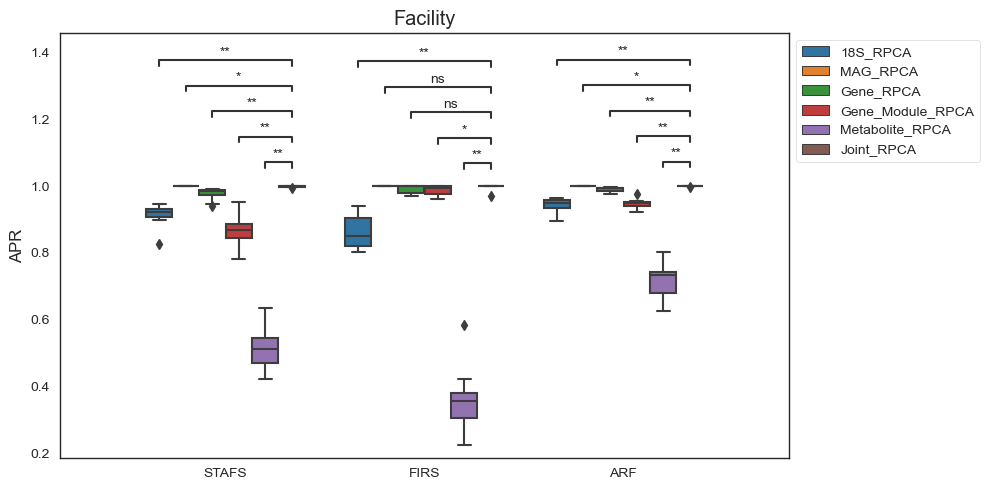

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

advanced_Metabolite_RPCA vs. advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
active_Metabolite_RPCA vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
early_Metabolite_RPCA vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
initial_Metabolite_RPCA vs. initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
active_Gene_Module_RPCA vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
early_Gene_Module_RPCA vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
initial_Gene_Module_RPCA vs. initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
advanced_Gene_Module_RPCA vs. advanced

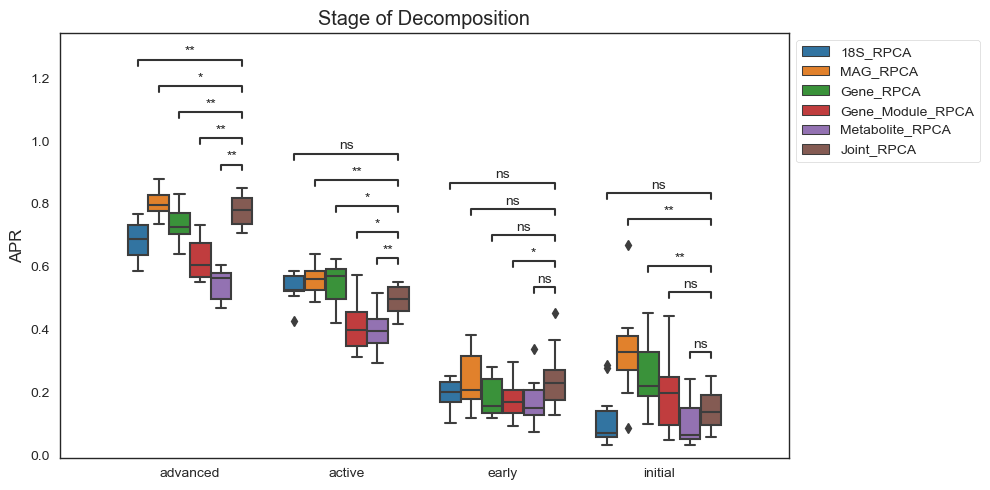

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

spring_Metabolite_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Metabolite_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Metabolite_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Metabolite_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Gene_Module_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Gene_Module_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Gene_Module_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
spring_Gene_Module_RPCA vs. spring_Joint_RPCA: Wil

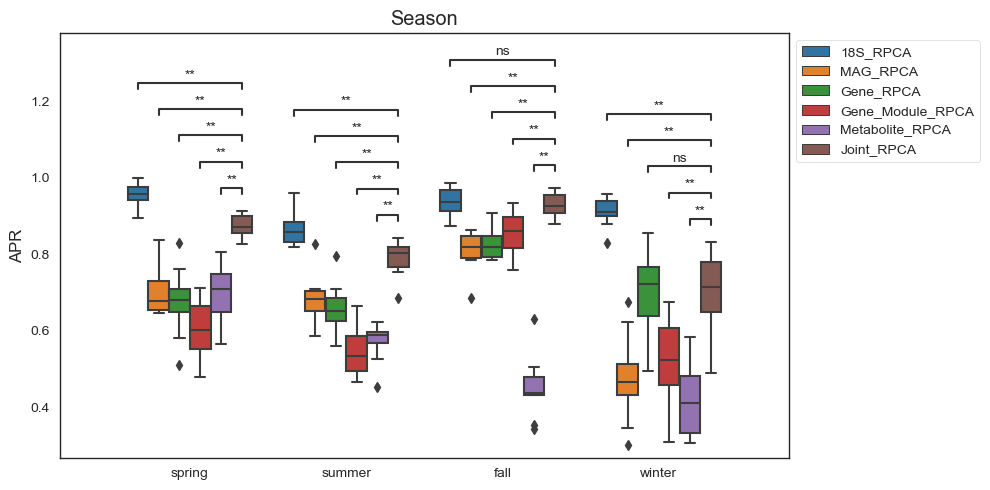

In [14]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
plotting_params = {'x':'Group', 'y':'AUC_APR', 
                   'palette':'tab10', 'hue':'Omic'}

#seaborn boxplot of individual APRs with stat test
for df, title in zip([apr_ord_facility, apr_ord_stage, apr_ord_season],
                     ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = df
    groups = df['Group'].unique()
    stat_pairs = [[(group, rpca), (group, "Joint_RPCA")] for
                    group in groups for rpca in rpca_types]

    plt.figure(figsize=(10, 5))
    ax_ = plt.gca()
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #x axis rotation
    #ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
    ax_.set_xlabel('')
    ax_.set_ylabel('APR')
    ax_.set_title(title)
    #plot legend outside of box
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [15]:
#calculate average AUC_APR for each fold
apr_avg_facility = pd.DataFrame(columns=['Omic', 'Fold', 'AUC_APR'])
apr_avg_stage = pd.DataFrame(columns=['Omic', 'Fold', 'AUC_APR'])
apr_avg_season = pd.DataFrame(columns=['Omic', 'Fold', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_ord_facility[apr_ord_facility['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_fac = pd.DataFrame(zip([fold_]*6, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_facility = pd.concat([apr_avg_facility, apr_avg_fac])

    avg2 = apr_ord_stage[apr_ord_stage['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_stage = pd.concat([apr_avg_stage, apr_avg_st])

    avg3 = apr_ord_season[apr_ord_season['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_se = pd.DataFrame(zip([fold_]*6, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_season = pd.concat([apr_avg_season, apr_avg_se])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.131e-02 Stat=0.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

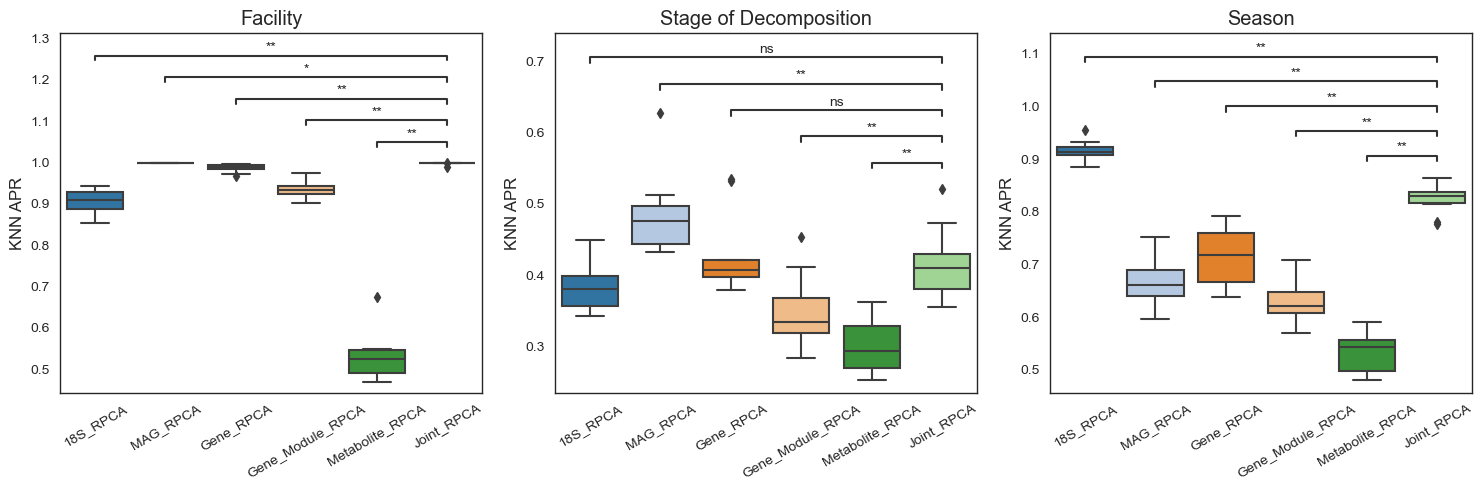

In [16]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [apr_avg_facility, apr_avg_stage, apr_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Binned stages of decomposition

In [17]:
#join early/initial together and active/advanced together
metadata_stage_binned = metadata.copy()
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'early', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'initial', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'active', 'add_0c_group'] = 'active/advanced'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'advanced', 'add_0c_group'] = 'active/advanced'

In [18]:
#sanity check
print(metadata.add_0c_group.value_counts())
print(metadata_stage_binned.add_0c_group.value_counts())

add_0c_group
advanced    162
active      142
early        47
initial      23
Name: count, dtype: int64
add_0c_group
active/advanced    304
early/initial       70
Name: count, dtype: int64


In [56]:
#STAGE OF DECOMPOSITION (BINNED)
ord_stage_binned = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata_stage_binned, cat_of_interest='add_0c_group')

(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)
(94, 2)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active/advanced_Metabolite_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
early/initial_Metabolite_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.223e-01 Stat=1.700e+01
early/initial_Gene_Module_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
active/advanced_Gene_Module_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.500e+01
active/advanced_Gene_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.500e+01
early/initial_Gene_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
active/advanced_MAG_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon te

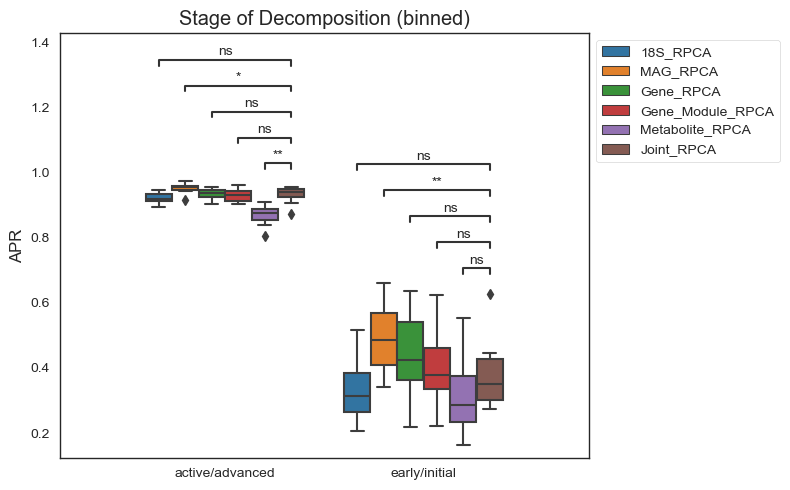

In [23]:
stages = ord_stage_binned.Group.unique()
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(stg, rpca), (stg, "Joint_RPCA")] for
                stg in stages for rpca in rpca_types]
plotting_params = {'x':'Group', 'y':'AUC_APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'data':ord_stage_binned}

#seaborn boxplot of individual APRs with stat test
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
#ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('APR')
ax_.set_title('Stage of Decomposition (binned)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [24]:
#calculate average AUC_APR for each fold
apr_avg_stage_binned = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:

    avg = ord_stage_binned[ord_stage_binned['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg.index, avg['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_stage_binned = pd.concat([apr_avg_stage_binned, apr_avg_st])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01


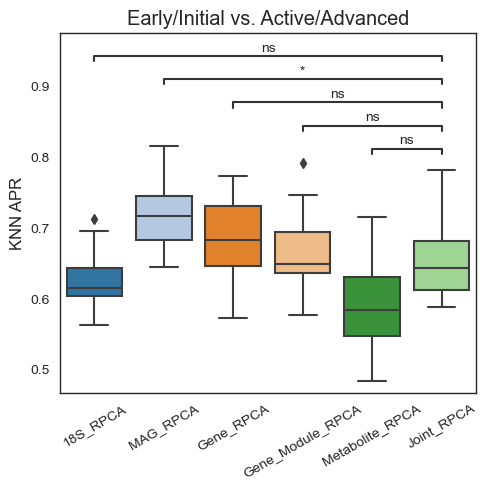

In [26]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order, 'palette':'tab20',
                   'data':apr_avg_stage_binned}

fig = plt.figure(figsize=(5, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
ax_.set_xlabel('')
ax_.set_ylabel('KNN APR')
ax_.set_title('Early/Initial vs. Active/Advanced')

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Accuracy

In [18]:
#FACILITY
acc_ord_facility = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata, cat_of_interest='facility', metric='Accuracy')

#save results
acc_ord_facility.to_csv('../results/joint-rpca/KNN/knn_acc_ord_facility_{}PCs.tsv'.format(nPCs), sep='\t')
display(acc_ord_facility.head())

,Omic,Fold,Accuracy,Report
0,18S_RPCA,traintest_0,0.840426,precision recall f1-score ...
1,18S_RPCA,traintest_1,0.808511,precision recall f1-score ...
2,18S_RPCA,traintest_2,0.776596,precision recall f1-score ...
3,18S_RPCA,traintest_3,0.829787,precision recall f1-score ...
4,18S_RPCA,traintest_4,0.819149,precision recall f1-score ...


In [19]:
#STAGE OF DECOMPOSITION
acc_ord_stage = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                        shared_mt=metadata, cat_of_interest='add_0c_group', metric='Accuracy')

#save results
acc_ord_stage.to_csv('../results/joint-rpca/KNN/knn_acc_ord_stage_{}PCs.tsv'.format(nPCs), sep='\t')
display(acc_ord_stage.head())

,Omic,Fold,Accuracy,Report
0,18S_RPCA,traintest_0,0.563830,precision recall f1-score ...
1,18S_RPCA,traintest_1,0.478723,precision recall f1-score ...
2,18S_RPCA,traintest_2,0.500000,precision recall f1-score ...
3,18S_RPCA,traintest_3,0.542553,precision recall f1-score ...
4,18S_RPCA,traintest_4,0.585106,precision recall f1-score ...


In [20]:
#SEASOn
acc_ord_season = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                     ord_gene_module, ord_metabolite, ord_joint],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                  "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                         shared_mt=metadata, cat_of_interest='season', metric='Accuracy')

#save results
acc_ord_season.to_csv('../results/joint-rpca/KNN/knn_acc_ord_season_{}PCs.tsv'.format(nPCs), sep='\t')
display(acc_ord_season.head())

,Omic,Fold,Accuracy,Report
0,18S_RPCA,traintest_0,0.904255,precision recall f1-score ...
1,18S_RPCA,traintest_1,0.861702,precision recall f1-score ...
2,18S_RPCA,traintest_2,0.893617,precision recall f1-score ...
3,18S_RPCA,traintest_3,0.819149,precision recall f1-score ...
4,18S_RPCA,traintest_4,0.904255,precision recall f1-score ...


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:6.459e-03 Stat=0.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

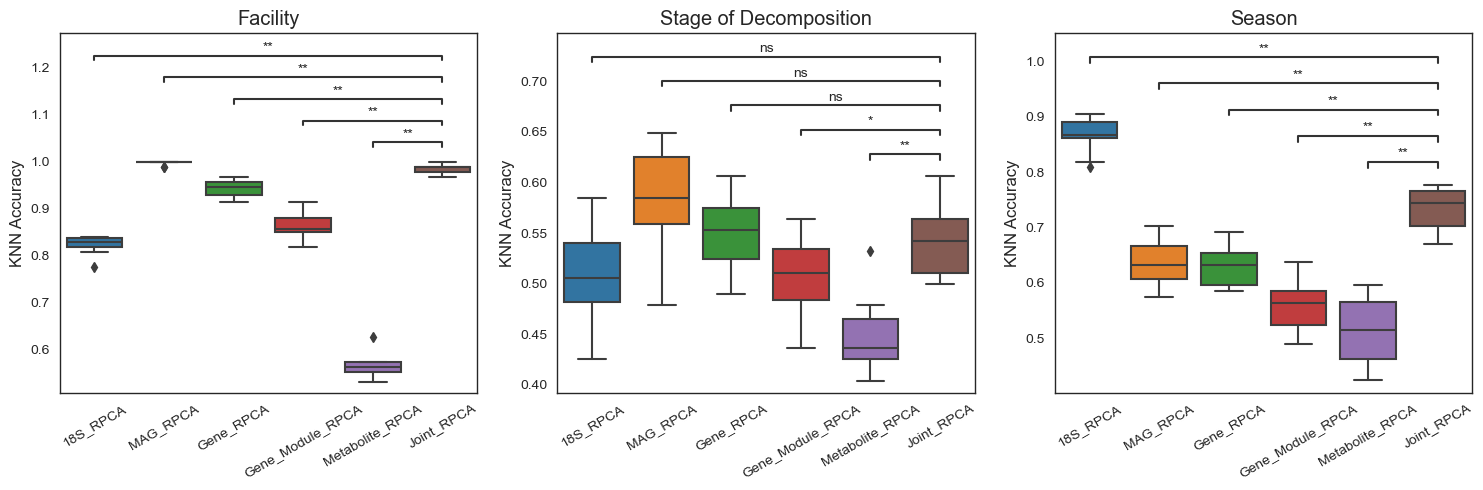

In [21]:
#plot results and run statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab10'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility, acc_ord_stage, acc_ord_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

## Feature-based classification

In [27]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [28]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [29]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


### Log-ratios

In [43]:
#common parameters
quantile = 0.90
pc_to_use = 'PC4'

In [44]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}
rpca_traj = {}

for omic in tables.keys():

    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]

    _, _, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                          quantile=quantile, pseudocount=0)
    rpca_traj[omic] = beta_l

#find top/bottom features from joint-RPCA results
joint_rpca_traj = {}

for omic in tables.keys():

    table_ = tables[omic]
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                          quantile=quantile, pseudocount=0)
    joint_rpca_traj[omic] = beta_l

### Average APRs

In [45]:
#FACILITY
apr_traj_facility = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                        rpca_traj['gene_module'], rpca_traj['metabolite'],
                                        joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                        joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                     "Gene_Module_RPCA", "Metabolite_RPCA",
                                     "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                     "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                            shared_mt=metadata, cat_of_interest='facility', ordination=False, metric='AUC_APR')
#STAGE OF DECOMPOSITION
apr_traj_stage = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                     rpca_traj['gene_module'], rpca_traj['metabolite'],
                                     joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                     joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                         shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, metric='AUC_APR')
#SEASON
apr_traj_season = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                      rpca_traj['gene_module'], rpca_traj['metabolite'],
                                      joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                      joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                          shared_mt=metadata, cat_of_interest='season', ordination=False, metric='AUC_APR')

In [46]:
apr_traj_avg_facility = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_traj_avg_stage = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_traj_avg_season = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_traj_facility[apr_traj_facility['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_fac = pd.DataFrame(zip([fold_]*10, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_facility = pd.concat([apr_traj_avg_facility, apr_avg_fac])

    avg2 = apr_traj_stage[apr_traj_stage['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*10, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_stage = pd.concat([apr_traj_avg_stage, apr_avg_st])

    avg3 = apr_traj_season[apr_traj_season['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_se = pd.DataFrame(zip([fold_]*10, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_season = pd.concat([apr_traj_avg_season, apr_avg_se])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wil

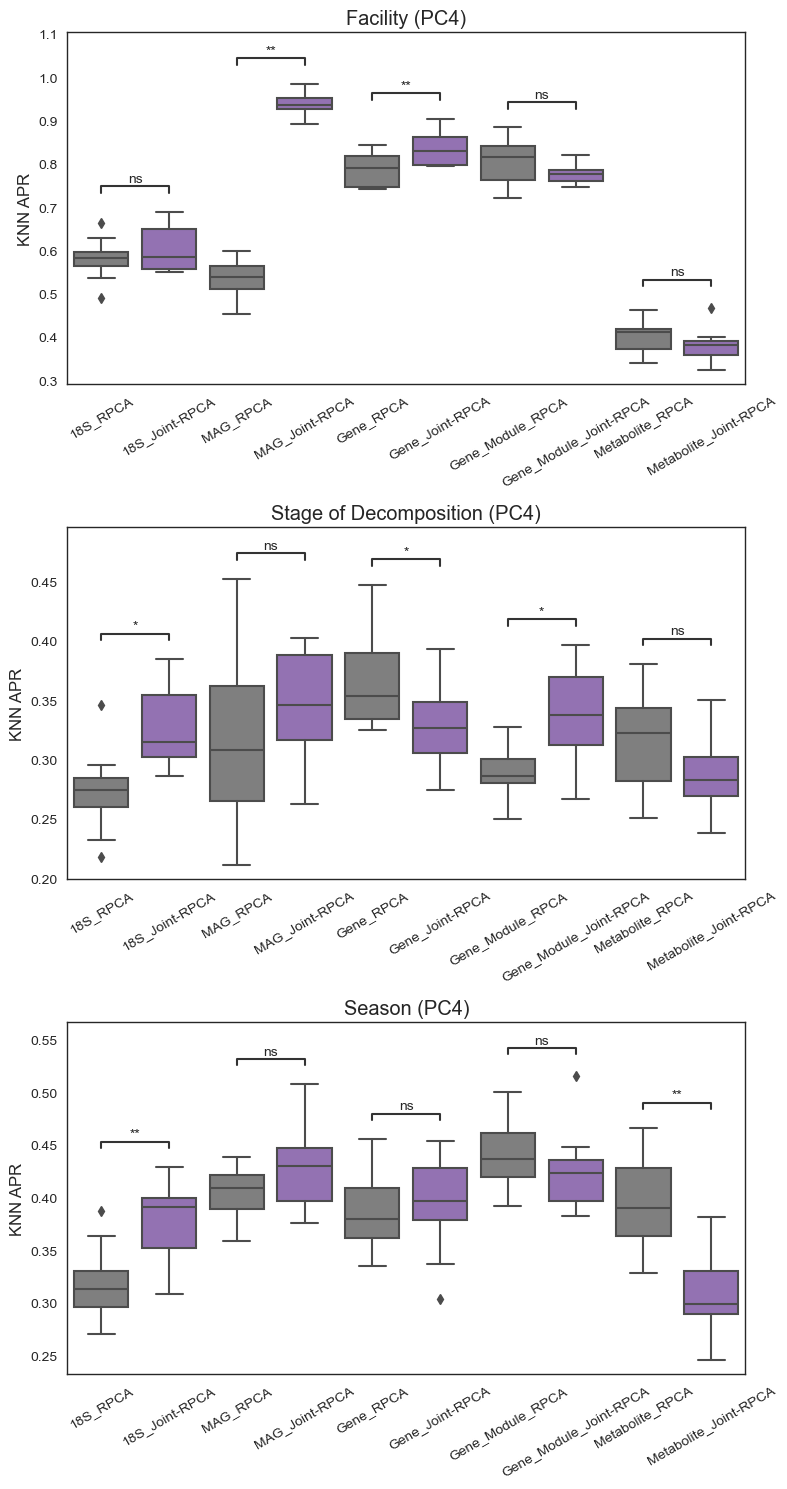

In [47]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [apr_traj_avg_facility, apr_traj_avg_stage, apr_traj_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

In [49]:
pc_ratio = {}
ml_name = 'KNN'
for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/{}/knn_acc_{}-ratio_{}_4PCs.tsv'.format(ml_name, pc, task),
                                sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [50]:
best_pc_per_task = {}
pc_ratio_best = {}

for task in ['facility', 'stage', 'season']:
    print(task)
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

    #store results in dataframe
    pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                              'Report', 'Optimization', 'PC'])

    for omic in result_dict.keys():
        pc_to_use = result_dict[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        pc_ratio_plotting = pc_ratio_plotting._append(pc_ratio_task, ignore_index=True)
    pc_ratio_best[task] = pc_ratio_plotting
    
    display(max_pc_per_omic)
    print()

facility


,Omic,PC,Accuracy
2,18S_Joint-RPCA,PC3,0.613953
7,18S_RPCA,PC4,0.666463
10,Gene_Joint-RPCA,PC3,0.893617
14,Gene_Module_Joint-RPCA,PC3,0.872340
19,Gene_Module_RPCA,PC4,0.787234
22,Gene_RPCA,PC3,0.808511
27,MAG_Joint-RPCA,PC4,0.925532
29,MAG_RPCA,PC2,0.909574
33,Metabolite_Joint-RPCA,PC2,0.478723
39,Metabolite_RPCA,PC4,0.526596



stage


,Omic,PC,Accuracy
1,18S_Joint-RPCA,PC2,0.487805
6,18S_RPCA,PC3,0.467126
9,Gene_Joint-RPCA,PC2,0.494681
13,Gene_Module_Joint-RPCA,PC2,0.500000
16,Gene_Module_RPCA,PC1,0.481297
21,Gene_RPCA,PC2,0.553191
25,MAG_Joint-RPCA,PC2,0.526882
30,MAG_RPCA,PC3,0.502745
35,Metabolite_Joint-RPCA,PC4,0.430851
36,Metabolite_RPCA,PC1,0.436170



season


,Omic,PC,Accuracy
1,18S_Joint-RPCA,PC2,0.488088
4,18S_RPCA,PC1,0.449367
8,Gene_Joint-RPCA,PC1,0.446809
15,Gene_Module_Joint-RPCA,PC4,0.425532
19,Gene_Module_RPCA,PC4,0.430851
20,Gene_RPCA,PC1,0.452128
25,MAG_Joint-RPCA,PC2,0.440210
29,MAG_RPCA,PC2,0.478723
34,Metabolite_Joint-RPCA,PC3,0.420213
38,Metabolite_RPCA,PC3,0.404255


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.055e-01 Stat=1.100e+01
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.219e-01 Stat=2.600e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

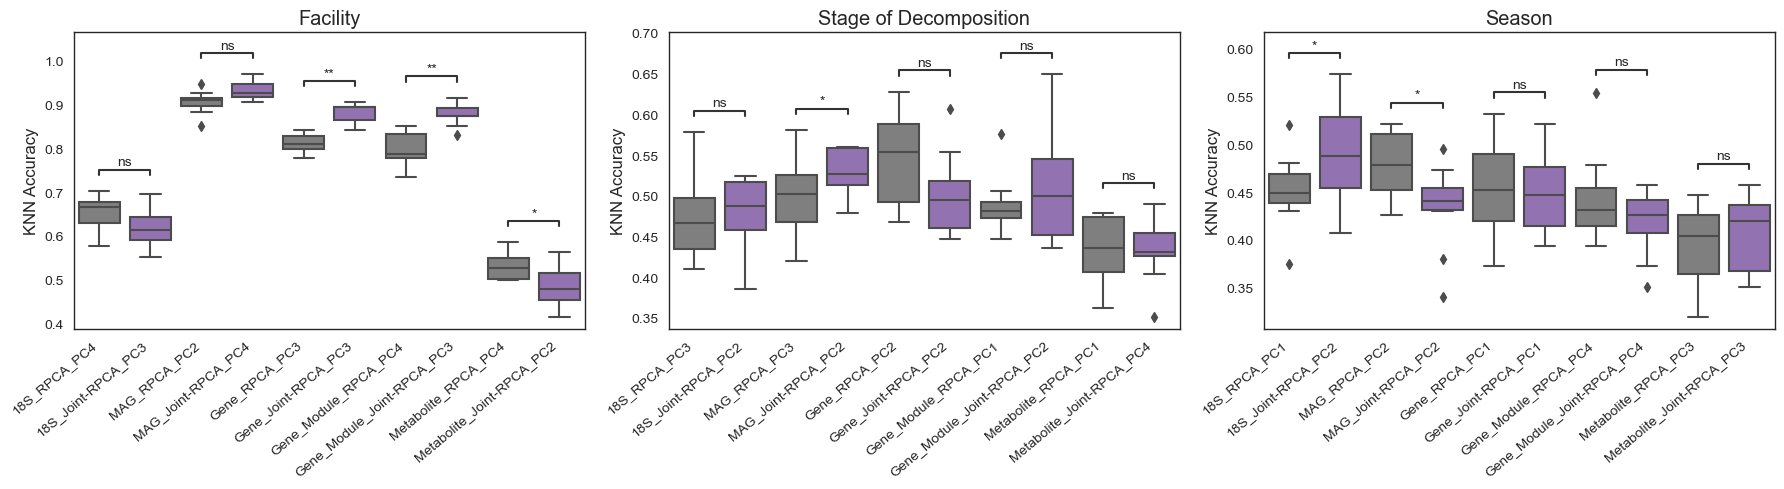

In [54]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(18, 5))

for ax_, task, title in zip(axn.flatten(), pc_ratio.keys(),
                           ['Facility', 'Stage of Decomposition', 'Season']):
    #get best PC per omic
    best_pc = best_pc_per_task[task]
    pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                              'Report', 'Optimization', 'PC'])

    for omic in best_pc.keys():
        pc_to_use = best_pc[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        pc_ratio_plotting = pc_ratio_plotting._append(pc_ratio_task, ignore_index=True)

    plotting_params['data'] = pc_ratio_plotting
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #update x tick labels
    mapping_dict = {}
    for omic, (pc, _) in best_pc_per_task[task].items():
        mapping_dict[omic] = '{}_{}'.format(omic, pc)

    current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
    updated_labels = [mapping_dict.get(label, label) for label in current_labels]

    ax_.set_xticklabels(updated_labels, rotation=40, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('{} Accuracy'.format(ml_name))
    ax_.set_title('{}'.format(title))

plt.tight_layout()
plt.show()

### Accuracy

In [ ]:
#FACILITY
acc_traj_facility = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                        rpca_traj['gene_module'], rpca_traj['metabolite'],
                                        joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                        joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                     "Gene_Module_RPCA", "Metabolite_RPCA",
                                     "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                     "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                            shared_mt=metadata, cat_of_interest='facility', ordination=False, metric='Accuracy')

#save results
acc_traj_facility.to_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_facility_{}PCs.tsv'.format(pc_to_use, nPCs), sep='\t')

In [ ]:
#STAGE OF DECOMPOSITION
acc_traj_stage = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                     rpca_traj['gene_module'], rpca_traj['metabolite'],
                                     joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                     joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                         shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, metric='Accuracy')

#save results
acc_traj_stage.to_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_stage_{}PCs.tsv'.format(pc_to_use, nPCs), sep='\t')

In [ ]:
#SEASON
acc_traj_season = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                      rpca_traj['gene_module'], rpca_traj['metabolite'],
                                      joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                      joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                          shared_mt=metadata, cat_of_interest='season', ordination=False, metric='Accuracy')

#save results
acc_traj_season.to_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_season_{}PCs.tsv'.format(pc_to_use, nPCs), sep='\t')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.474e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wil

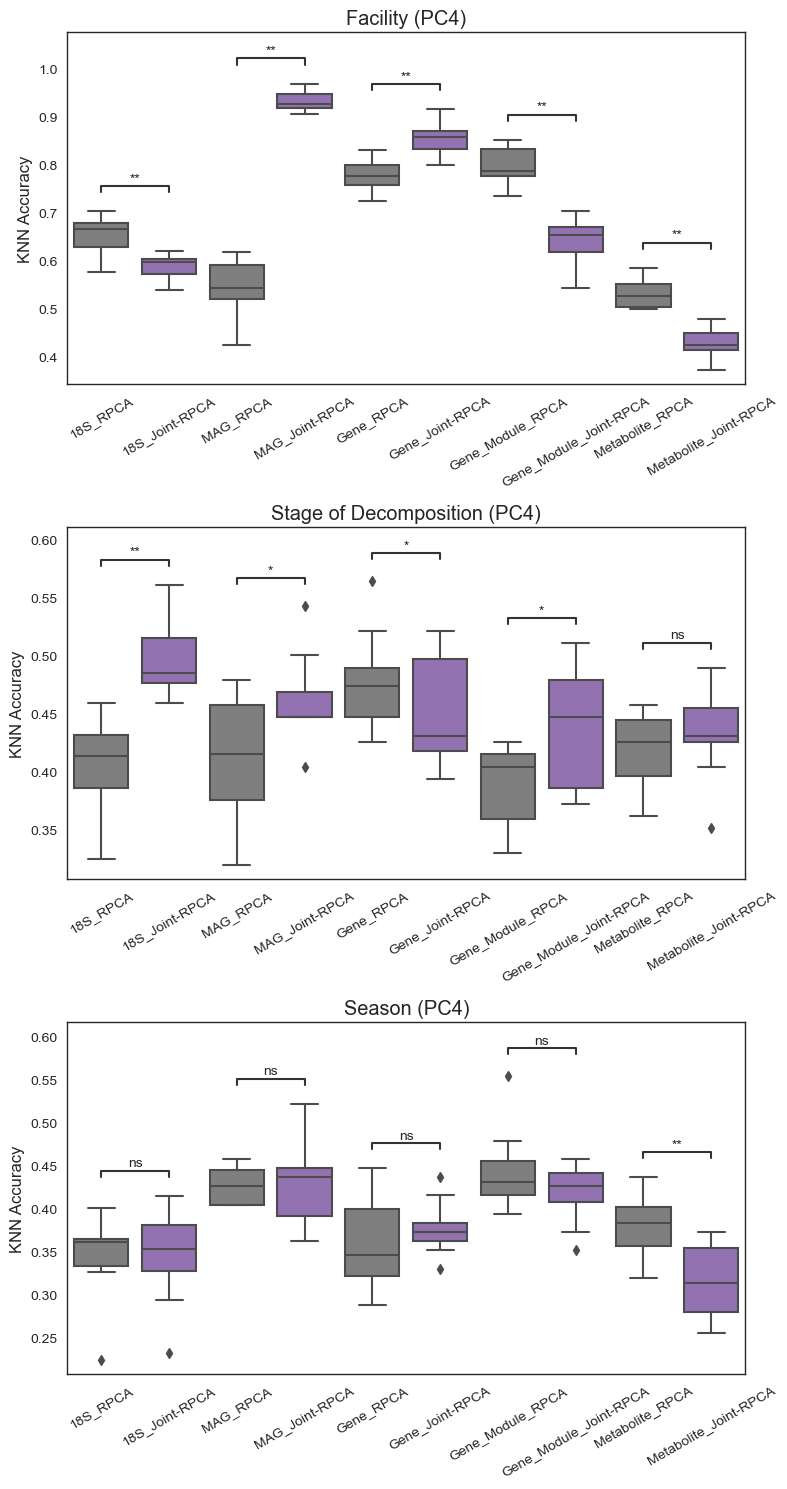

In [ ]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [acc_traj_facility, acc_traj_stage, acc_traj_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN Accuracy')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()